In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import pandas as pd
import yaml
import geopandas as gp
import time
import pandas as pd
from geopy.distance import great_circle
import folium
import h5py
from scipy.signal import butter, lfilter

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_regular_v9.5_3x7/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_regular_v9.5_5x13/


In [7]:
name_projects = []
name_projects.append('project/output_regular_v9.5_3x7/')
name_projects.append('project/output_regular_v9.5_5x13/')
name_projects.append('project/output_regular_v9.5_7x19/')
name_projects.append('project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/')

In [8]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [9]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
dir_disp_probes  = dir_project_probes + info_basic_probes['rdir_disp_autopick'] 
dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo/'
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [10]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [11]:
key_subworks_all = info_basic['key_subworks']
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

In [12]:
stations_this = {}
lat_stations_this = {}
lon_stations_this = {}
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_this[key] = stations_this
    lat_stations_this[key] = lat.astype(float)
    lon_stations_this[key] = lon.astype(float)

In [13]:
stations_probes = {}
lat_probes = {}
lon_probes = {}
lon_centroid_probes = []
lat_centroid_probes = []
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_this.astype(float)
    lon_probes[probe] = lon_this.astype(float)
    lon_centroid_probes.append(np.mean(lon_this.astype(float)))
    lat_centroid_probes.append(np.mean(lat_this.astype(float)))

In [14]:
stations_targets = {}
lat_targets = {}
lon_targets = {}
lon_centroid_targets = []
lat_centroid_targets = []
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)
    lon_centroid_targets.append(np.mean(lon_this.astype(float)))
    lat_centroid_targets.append(np.mean(lat_this.astype(float)))

In [15]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

### probe and target

In [16]:
def extract_probes(target):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stations_targets

    stas = stations_targets[target]
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [17]:
def find_nearest(lon_this,lat_this,lon_stations_all,lat_stations_all):
    lon_stations_all = np.array(lon_stations_all)
    lat_stations_all = np.array(lat_stations_all)
    lon_stations_all = lon_stations_all.reshape(-1,1)
    lat_stations_all = lat_stations_all.reshape(-1,1)
    dist = np.sqrt((lon_stations_all-lon_this)**2+(lat_stations_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    #print(lon_stations_all)
    #print(index)
    return index

In [18]:
key_subwork = '277--26-10'
key_probe = '24-11'
key_target = '26-10'
f_range = [10,16]

points = np.column_stack((lon_targets[key_target],lat_targets[key_target]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_target = list(points[hull.vertices,0])
lon_edge_target.append(points[hull.vertices,0][0])
lat_edge_target = list(points[hull.vertices,1])
lat_edge_target.append(points[hull.vertices,1][0])

points = np.column_stack((lon_probes[key_probe],lat_probes[key_probe]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_probe = list(points[hull.vertices,0])
lon_edge_probe.append(points[hull.vertices,0][0])
lat_edge_probe = list(points[hull.vertices,1])
lat_edge_probe.append(points[hull.vertices,1][0])

# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
disp_all = {}
for probe in probes_this:
    file_ds = dir_disp_probes + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
    disp_all[probe] = disp[index,:]
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])
# calculate relative error between all probes and reference probe
err = []
f_sample = np.linspace(f_range[0],f_range[1],200,endpoint=False)
f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
c_pick_ref = f(f_sample)
c_pick = {}
for probe in probes_this:
    c_pick[probe] = []
    file_ds = dir_disp_probes + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
    disp = disp[index,:]
    f_this = disp[:,0]
    c_this = disp[:,1]
    # 生成插值函数,可以外推
    #f = interpolate.interp1d(f_this,c_this,kind='cubic')
    f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
    c_pick[probe] = f(f_sample)

    max_disp = np.sum( np.maximum(np.array(c_pick_ref),np.array(c_pick[probe])) )
    abs_err = np.sum( np.abs(np.abs(np.array(c_pick_ref))-np.abs(np.array(c_pick[probe]))) )
    err.append(abs_err/max_disp) 

26-10
26-10
277--26-10


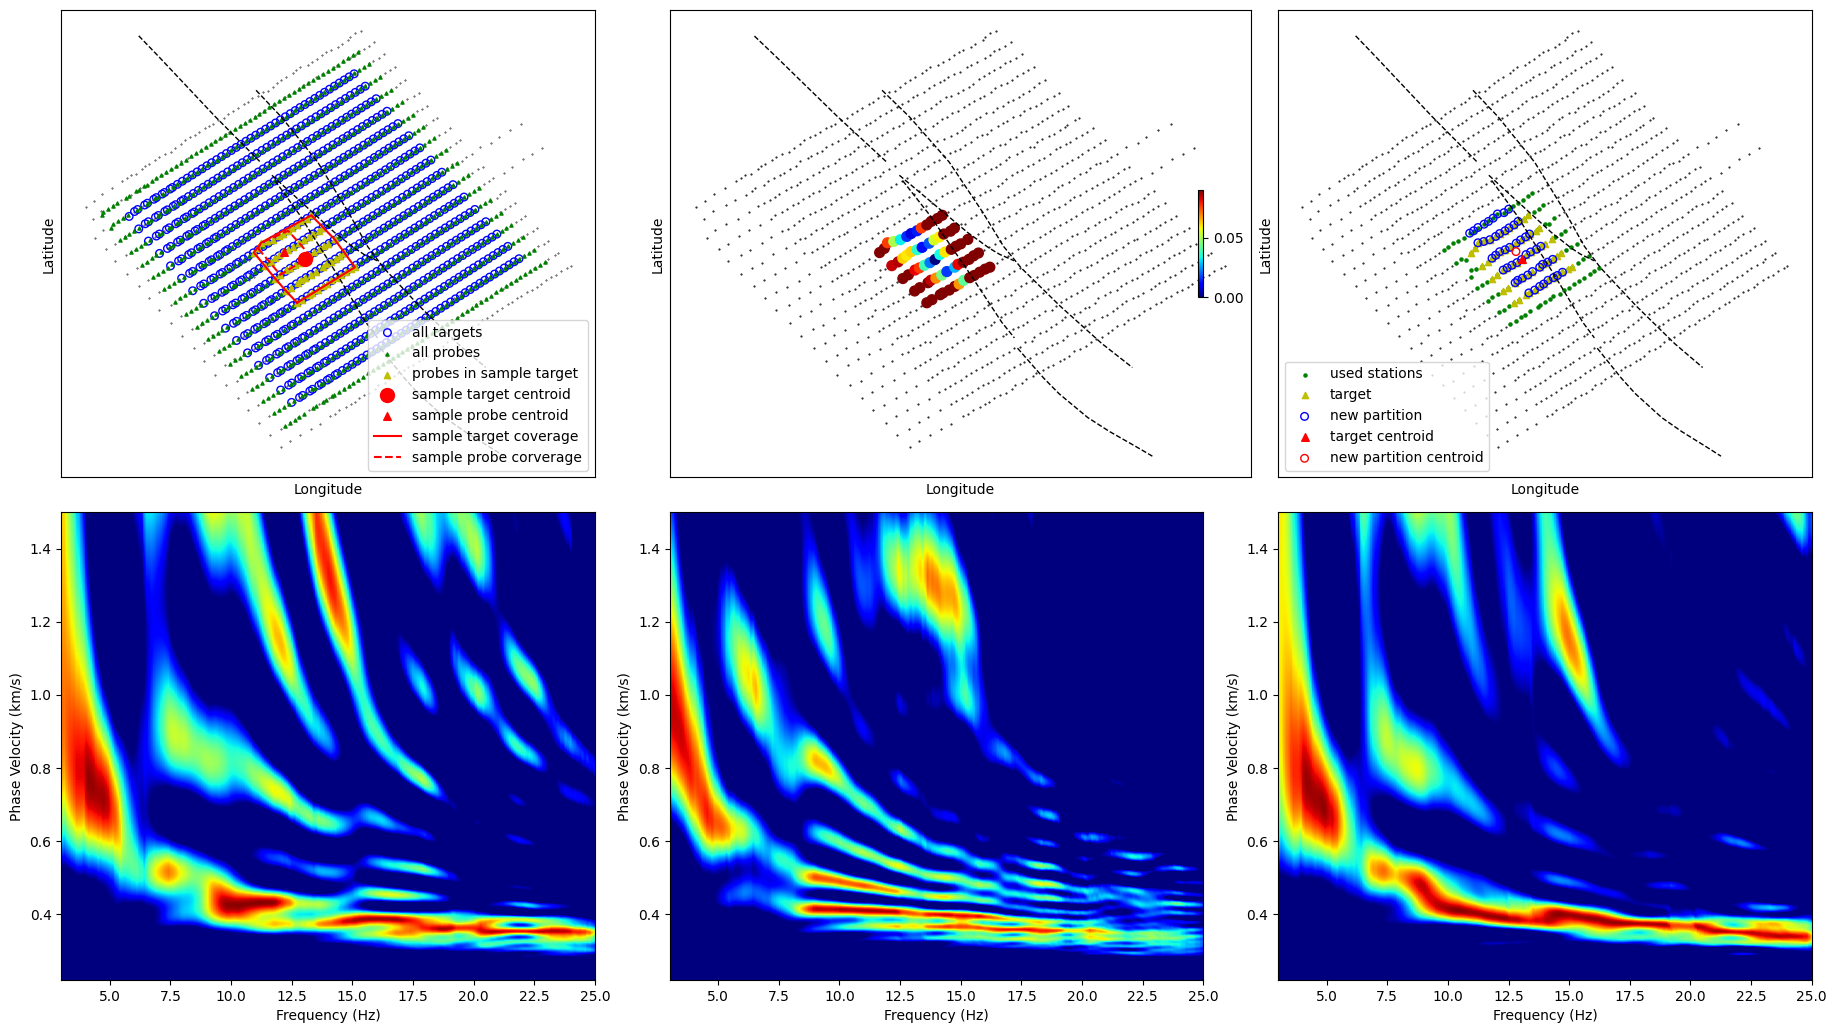

In [27]:
fig = plt.figure(figsize=(18,10))

ax_tar_pro = fig.add_subplot(2,3,1)
ax_tar_pro.scatter(lon_stations_all,lat_stations_all,marker='.',c = 'k',s = 0.5)
for j in range(len(faults)):
    if j == 0:
        ax_tar_pro.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
    else:
        ax_tar_pro.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
ax_tar_pro.set_xlabel('Longitude')
ax_tar_pro.set_ylabel('Latitude')
ax_tar_pro.set_xticks([])
ax_tar_pro.set_yticks([])
#ax_tar_pro.scatter(lon_targets[key_target],lat_targets[key_target],marker='o',c = 'r',s = 10)
ax_tar_pro.scatter(lon_centroid_targets,lat_centroid_targets,marker='o',s = 30, edgecolors='b', facecolors='none', label = 'all targets')
ax_tar_pro.scatter(lon_centroid_probes,lat_centroid_probes,marker='^',c = 'g',s = 5,label = 'all probes')
ax_tar_pro.scatter(lon_targets[key_target],lat_targets[key_target],c = 'y',s = 20,marker = '^',label = 'probes in sample target')
ax_tar_pro.scatter(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],c='r',s = 100,label = 'sample target centroid')
ax_tar_pro.scatter(lon_centroid_probes[probes.index(key_probe)],lat_centroid_probes[probes.index(key_probe)],c='r',s = 30,marker = '^',label = 'sample probe centroid')
ax_tar_pro.plot(lon_edge_target,lat_edge_target,c = 'r',label = 'sample target coverage')
ax_tar_pro.plot(lon_edge_probe,lat_edge_probe,'r--',label = 'sample probe corverage')
ax_tar_pro.legend()

ax_error = fig.add_subplot(2,3,2)
ax_error.scatter(lon_stations_all,lat_stations_all,marker='.',c = 'k',s = 1,label = 'Stations')
for j in range(len(faults)):
    if j == 0:
        ax_error.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1,label = 'fault trace')
    else:
        ax_error.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
ax_error.set_xlabel('Longitude')
ax_error.set_ylabel('Latitude')
ax_error.set_xticks([])
ax_error.set_yticks([])
im = ax_error.scatter(lon_targets[key_target],lat_targets[key_target],c=err,s=50,cmap='jet')
im.set_clim(vmin=0,vmax=0.09)
fig.colorbar(im, ax=ax_error,fraction=0.01,pad=-0.1)

ax_partition = fig.add_subplot(2,3,3)
ax_partition.scatter(lon_stations_all,lat_stations_all,marker='.',c = 'k',s = 1)
for j in range(len(faults)):
    if j == 0:
        ax_partition.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
    else:
        ax_partition.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
ax_partition.set_xlabel('Longitude')
ax_partition.set_ylabel('Latitude')
ax_partition.set_xticks([])
ax_partition.set_yticks([])
ax_partition.scatter(lon_stations_original,lat_stations_original,marker='o',c = 'g',s = 5,label = 'used stations')
ax_partition.scatter(lon_targets[key_target],lat_targets[key_target],c = 'y',s = 20,marker = '^',label = 'target')
ax_partition.scatter(lon_stations_this[key_subwork],lat_stations_this[key_subwork],marker='o',edgecolors='b', facecolors='none',s = 30,label = 'new partition')
ax_partition.scatter(np.mean(lon_targets[key_target]),np.mean(lat_targets[key_target]),c = 'r',s = 30,marker = '^',label = 'target centroid')
ax_partition.scatter(np.mean(lon_stations_this[key_subwork]),np.mean(lat_stations_this[key_subwork]),edgecolors='r', facecolors='none',s = 30,marker = 'o',label = 'new partition centroid')
ax_partition.legend()
plt.tight_layout()

name_projects = []
keys = []
name_projects.append('project/output_regular_v9.5_5x13/')
keys.append(key_target)
name_projects.append('project/output_regular_v9.5_7x19/')
keys.append(key_target)
name_projects.append(name_project)
keys.append(key_subwork)

for i in range(3):
    ax_fj = fig.add_subplot(2,3,4+i)
    key_this = keys[i]
    print(key_this)
    name_project_this = name_projects[i]
    dir_project_this = dir_project_workspace + name_project_this
    filename = dir_project_this+'Basic_info.yml'
    with open(filename, 'r', encoding='utf-8') as f:
        info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
    dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
    c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
    ds = h5py.File(dir_ds_this+'ds_'+str(key_this)+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    ds_remove = plotlib.smooth_ds(ds_remove)
    f0 = ds['f'][:]
    ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0),max(f0),min(c),max(c)],vmin=0.1,vmax = 1, cmap = 'jet')
    ax_fj.set_xlim([3,25])
    ax_fj.set_ylim([0.22,1.5])
    ax_fj.set_xlabel('Frequency (Hz)')
    ax_fj.set_ylabel('Phase Velocity (km/s)')